In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls "/content/drive/MyDrive/aerial_project/saved_models"

best_custom_cnn.h5	   best_efficientnet.h5  history_custom_cnn.pkl
best_efficientnet_full.h5  class_names.json	 history_efficientnet.pkl


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Paths
PROJECT_ROOT='/content/drive/MyDrive/aerial_project'
CLASSIFICATION_DIR=os.path.join(PROJECT_ROOT, 'classification_dataset')
SAVED_MODELS=os.path.join(PROJECT_ROOT, 'saved_models')
RESULTS_DIR=os.path.join(PROJECT_ROOT, 'results')

os.makedirs(RESULTS_DIR, exist_ok=True)
#Load models
custom_cnn=tf.keras.models.load_model(os.path.join(SAVED_MODELS, 'best_custom_cnn.h5'))
efficientnet=tf.keras.models.load_model(os.path.join(SAVED_MODELS, 'best_efficientnet.h5'))
print("Models loaded successfully!")

Models loaded successfully!


In [4]:
#Load test data(no rescale here since the model has Rescaling layer)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE=(224, 224)
BATCH_SIZE=32
#Avoiding rescale here because my models already include layers.Rescaling(1./255)
test_datagen=ImageDataGenerator()  #thus no rescale
test_gen=test_datagen.flow_from_directory(
    os.path.join(CLASSIFICATION_DIR, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',   #Matches training's integer labels
    shuffle=False)

print("Class indices (from generator):", test_gen.class_indices)

Found 215 images belonging to 2 classes.
Class indices (from generator): {'bird': 0, 'drone': 1}


In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd
def evaluate_model(model, test_gen, model_name):
    #Step1:Getting true labels (generator stores them)
    y_true=test_gen.classes.copy()                 #shape (N,)
    #Step2:Predicting for all images in generator
    preds=model.predict(test_gen, verbose=1)       #shape(N, 2) for softmax or (N,1) for sigmoid
    #Step3:converting predictions to class indices and confidences robustly
    if preds.ndim == 2 and preds.shape[1] == 2:
        y_pred=np.argmax(preds, axis=1)
        confidences=np.max(preds, axis=1)
    else:
        #model outputs single probability for class 1
        probs=preds.ravel()
        y_pred=(probs > 0.5).astype(int)
        confidences=np.maximum(probs, 1-probs)  #confidence=max(prob(class1), prob(class0))

    #Safety: trim to same length if anything odd happens
    min_len=min(len(y_true), len(y_pred))
    y_true=y_true[:min_len]
    y_pred=y_pred[:min_len]
    confidences=confidences[:min_len]
    #metrics
    acc=accuracy_score(y_true, y_pred)
    prec=precision_score(y_true, y_pred, zero_division=0)
    rec=recall_score(y_true, y_pred, zero_division=0)
    f1=f1_score(y_true, y_pred, zero_division=0)
    #displaying
    print(f"\n{model_name} Metrics:")
    print(classification_report(y_true, y_pred, digits=3))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    #returning the dictionary with extra info
    return {
        "Model": model_name,
        "Accuracy": round(acc, 3),
        "Precision": round(prec, 3),
        "Recall": round(rec, 3),
        "F1-Score": round(f1, 3),
        "AvgConfidence": float(np.mean(confidences)),
        "Confidences": confidences,
        "y_true": y_true,
        "y_pred": y_pred}

In [6]:
#call evaluation
custom_results=evaluate_model(custom_cnn, test_gen, "Custom CNN")
efficientnet_results=evaluate_model(efficientnet, test_gen, "EfficientNetB0")

#create comparison table (summary)
comparison_df=pd.DataFrame([
    {k: custom_results[k] for k in ["Model","Accuracy","Precision","Recall","F1-Score","AvgConfidence"]},
    {k: efficientnet_results[k] for k in ["Model","Accuracy","Precision","Recall","F1-Score","AvgConfidence"]}
])
comparison_df.to_csv(os.path.join(RESULTS_DIR, "model_comparison.csv"), index=False)
display(comparison_df)

#Show per-image predictions & confidences for the first model as a sample table:
names_path=os.path.join(SAVED_MODELS, 'class_names.json')
if os.path.exists(names_path):
    import json
    class_names=json.load(open(names_path))
else:
    class_names=['bird','drone']  #fallback

#Build per-image DataFrame
df_custom = pd.DataFrame({
    'filename': test_gen.filenames,
    'true_label': [class_names[int(i)] for i in custom_results['y_true']],
    'pred_label': [class_names[int(i)] for i in custom_results['y_pred']],
    'confidence': custom_results['Confidences']
})
#show first 20 rows
display(df_custom.head(20))
#Print average confidence numbers
print("Custom CNN average confidence:", round(custom_results['AvgConfidence'], 4))
print("EfficientNetB0 average confidence:", round(efficientnet_results['AvgConfidence'], 4))

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 7s/step

Custom CNN Metrics:
              precision    recall  f1-score   support

           0      0.836     0.760     0.797       121
           1      0.724     0.809     0.764        94

    accuracy                          0.781       215
   macro avg      0.780     0.784     0.780       215
weighted avg      0.787     0.781     0.782       215

Confusion Matrix:
 [[92 29]
 [18 76]]
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 556ms/step

EfficientNetB0 Metrics:
              precision    recall  f1-score   support

           0      0.655     0.314     0.425       121
           1      0.471     0.787     0.590        94

    accuracy                          0.521       215
   macro avg      0.563     0.551     0.507       215
weighted avg      0.575     0.521     0.497       215

Confusion Matrix:
 [[38 83]
 [20 74]]


,Model,Accuracy,Precision,Recall,F1-Score,AvgConfidence
0,Custom CNN,0.781,0.724,0.809,0.764,0.793080
1,EfficientNetB0,0.521,0.471,0.787,0.590,0.561754


,filename,true_label,pred_label,confidence
0,bird/00083b384685315d_jpg.rf.abfd1b2cc8c681777...,bird,bird,0.867470
1,bird/00188d7f40a84793_jpg.rf.7f9da2b662dc236fb...,bird,bird,0.960711
2,bird/0028adf0e92c3da2_jpg.rf.48c97d30547a46e83...,bird,bird,0.989576
3,bird/00347cbbeed4bedb_jpg.rf.aa19c9a7a22d76f85...,bird,bird,0.938021
4,bird/004cc8de466969bc_jpg.rf.ca1ffa31f30a92a39...,bird,bird,0.860966
5,bird/006ce62a72df4dd4_jpg.rf.8f8e7b6e9a26a01be...,bird,bird,0.654361
6,bird/006f6769070fc876_jpg.rf.bda2b07a999cd5899...,bird,bird,0.739917
7,bird/007321d46c4b8ffe_jpg.rf.bdea1bdbdba77545b...,bird,drone,0.817387
8,bird/0078fb03bcd9e384_jpg.rf.66436160110f88109...,bird,drone,0.627691
9,bird/0085fed0b90de5ba_jpg.rf.ace2ac82f6145bc68...,bird,bird,0.994207


Custom CNN average confidence: 0.7931
EfficientNetB0 average confidence: 0.5618


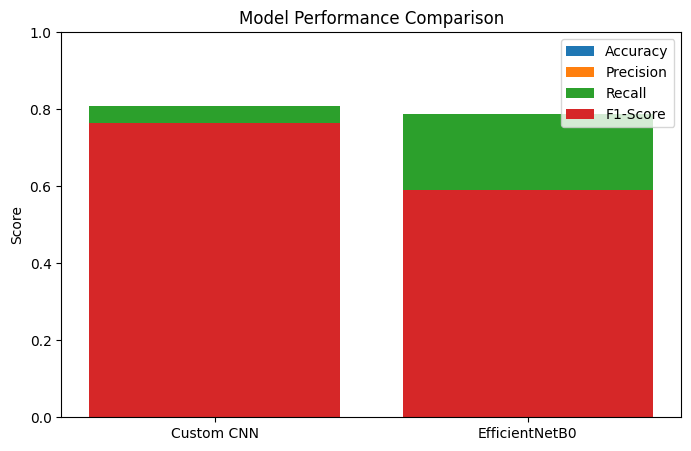

In [7]:
#Bar chart comparison
plt.figure(figsize=(8, 5))
metrics=['Accuracy', 'Precision', 'Recall', 'F1-Score']
for metric in metrics:
    plt.bar(comparison_df['Model'], comparison_df[metric], label=metric)

plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(metrics)
plt.show()

In [8]:
#Saving plots
fig_path=os.path.join(RESULTS_DIR, "comparison_plot.png")
plt.savefig(fig_path)
print(f"Comparison plot saved at: {fig_path}")

Comparison plot saved at: /content/drive/MyDrive/aerial_project/results/comparison_plot.png


<Figure size 640x480 with 0 Axes>